In [1]:
# Visualizes results

#list dir for all the log files 
import glob
import matplotlib.pyplot as plt
import os
from collections import defaultdict, OrderedDict
import numpy as np
import json
import seaborn as sns
import math 
import ast

def getkey_gtfix(f):
    gt = f[f.find('pred_label_gt')+len('pred_label_gt'):f.find('pred_label_gt')+len('pred_label_gt')+4] 
    return int(gt[-2:-1])

def getkey_pfix(f):
    gt = f[f.find('pred_label_gt')+len('pred_label_gt'):f.find('pred_label_gt')+len('pred_label_gt')+2] 
    x = f.find('pred_label')
    if gt == '5p':
        return 5
    return int(gt)


met = ['AP-' + cat for cat in ['chair', 'cushion', 'indoor-plant', 'door', 'table', 'sofa']]
met.insert(0, 'AP')

# class PlotMeanVar:
#     def __init__(self, )

# class AlphaMetrics:
#     def __init__(self):
        
# class BetaMetrics:
#     def __init__(self):
        

def plot(bboxa, bboxd, segma, segmd, xlabel):
    
    def unpack(x):
        res = []
        err = []
        for k, v in x.items():
            res.append(v['mean'])
            err.append(v['std'])
        return res, err
    
    a, b = unpack(bboxa)
    c, d = unpack(bboxd)
    
    # always plot keys on the x-axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), dpi=100)
    ax1.set_title('bbox')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('AP50')
    ax1.errorbar(bboxa.keys(), a, yerr=b, label='active')
    ax1.errorbar(bboxd.keys(), c, yerr=d, label='baseline')
    ax1.legend(loc="lower right")

    a, b = unpack(segma)
    c, d = unpack(segmd)
    
    
    ax2.set_title(f'segm')
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('AP50')
    ax2.errorbar(segma.keys(), a, yerr=b, label='active')
    ax2.errorbar(segmd.keys(), c, yerr=d, label='baseline')
    ax2.legend(loc="lower right")

    plt.show()
    
class MeanVar:
    def __init__(self, arr):
        self.arr = arr
        self.mean = np.mean(arr)
        self.var = np.var(arr)

class HyperParams:
    def __init__(self, lr, warmup, iters):
        self.lr = lr
        self.warmup = warmup
        self.iters = iters
        
    def __eq__(self, other): 
        if not isinstance(other, HyperParams):
            # don't attempt to compare against unrelated types
            return NotImplemented
        return self.lr == other.lr and self.warmup == other.warmup and self.iters == other.iters
    
    def setAP(self, bbox, segm):
        self.bbox = bbox
        self.segm = segm
    
    def get_file_name_pref(self):
        return f'{self.lr} {self.warmup} {self.maxiters} *.txt'
    
    def __repr__(self):
        return f'lr {self.lr} warmup {self.warmup} iters {self.iters}'
    
def process_hpm(x):
    x = x.strip()
    x = x.split()
#     print(x)
    assert len(x) == 6
    return HyperParams(lr=float(x[1]), warmup=int(x[3]), iters=int(x[5]))

def process_met(x):
    x = x.strip()
    x = ast.literal_eval(x)
    assert type(x) == dict
#     print(type(x), x)
    return x['bbox']['AP'], x['segm']['AP']
    
def shorten(outdir):
    if "straightline" in outdir: # baseline
        return "active " + "/".join(outdir.split('/')[-3:])
    return "baseline " + "/".join(outdir.split('/')[-2:])

def get_test_score(outdir, bh):
    tfs = glob.glob(outdir + '/**/' + os.path.join(str(bh.lr), str(bh.warmup), 'test_results.txt'))
    assert len(tfs) == 1
    tf = tfs[0]
#     tf = os.path.join(outdir, '500', str(bh.lr), str(bh.warmup), 'test_results.txt')
    if not os.path.isfile(tf):
        print(f'{tf} does not exist!!')
        
    # read the line with bhpm
    res = None
    bbox = []
    segm = []
    with open(tf) as f:
        lines = f.readlines()
        for i in range(0, len(lines), 4):
#             print(f'i {lines[i]}')
#             print(f'i+1 {lines[i+1]}')
            hpm = process_hpm(lines[i])
            if hpm == bh:
#                 res found
                for j in range(3):
                    bb, ss = process_met(lines[i+1+j])
                    bbox.append(bb)
                    segm.append(ss)
                break
#     print(f'testAP {res}')
#     return bbox, segm
    if len(bbox) == 0:
        print(f'No test AP for {bh.lr, bh.warmup}')
        return [0], [0] 
    return [np.mean(bbox)], [np.mean(segm)]

def get_best_test_ap(outdir, pref):
#     print(f'read_results {outdir}')
    bbox, segm = get_best_hyperparam_file(outdir, pref)
#     print(f'best hyperparams for {shorten(outdir)}, {bh if bh else None}')
    
#     if bh:
#         bbox, segm = get_test_score(outdir, bh)
#         print(f'bbox mean AP {np.mean(bbox)}, segm mean AP {np.mean(segm)}')
    return MeanVar([bbox]), MeanVar([segm])

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

def process(l, f, pref):
    def get_val_key(l, pref):
        l = l.split('/')
        if len(pref) > 0:
            k = "/".join(l[-8:-5]) + '_val' + l[-5]
        else:
            k = l[-7] + '/' + l[-6] + '_val' + l[-5]
#         print(k)
        return k

    def get_test_key(l, pref):
        l = l.split('/')
        if len(pref) > 0:
            k = "/".join(l[-8:-5]) + '_test_0_' + l[-5]
        else:
            k = l[-7] + '/' + l[-6] + '_test_0_' + l[-5]
#         print(k)
        return k
    
    val_key = get_val_key(f, pref)
    test_key = get_test_key(f, pref)
    
    keys = [
        'iteration', 
        'validation_loss', 
        f'{val_key}/bbox/AP', 
        f'{val_key}/segm/AP',
        f'{test_key}/bbox/AP', 
        f'{test_key}/segm/AP'
    ]
    
#     print(f'{l}, val_key {val_key}, test_key {test_key}')
#     print(keys)
    vals = {}
    for k in keys:
        if k in l:
            if k == f'{val_key}/bbox/AP':
                vals.update({'val/bbox':l[k]})
            elif k == f'{val_key}/segm/AP':
                vals.update({'val/segm':l[k]})
            elif k == f'{test_key}/bbox/AP':
                vals.update({'test/bbox':l[k]})
            elif k == f'{test_key}/segm/AP':
                vals.update({'test/segm':l[k]})
            else:
                vals.update({k:l[k]})
    
#     if len(vals) > 1:
#     print(vals)
    return vals

# def process(l, f):
#     def get_val_key(l):
#         l = l.split('/')
#         k = l[-6] + '_val' + l[-5]
# #         print(k)
#         return k
    
        
#     keys = ['iteration', 'validation_loss', 'bbox/AP', 'segm/AP']
#     vals = {}
#     for k in keys:
#         if k in l:
# #             print(l[k])
#             vals.update({k:l[k]})
    
# #     if len(vals) > 1:
# #         print(vals)
#     return vals

def get_best_hyperparam_file(outdir, pref):
    metric_jsons = glob.glob(outdir + '/**/metrics.json', recursive=True) # get all the validation files
#     print(f'globbed {len(metric_jsons)} metric jsons {metric_jsons}')
    best_val = 1000000
    best_val_ap = 0
    bb = 0
    ss = 0
    for m in metric_jsons:
#         print(f'looking at {x}\n')
        x = load_json_arr(m)
        for l in x:
#             print(l)
            vals = process(l, m, pref)
#             
            if 'validation_loss' in vals and 'val/bbox' in vals and 'test/bbox' in vals:
#                 if vals['val/bbox'] + vals['val/segm'] > best_val_ap:
#                     bb = vals['test/bbox']
#                     ss = vals['test/segm']
#                     best_val_ap = bb + ss
                    
#                 print(vals)
                val_loss = vals['validation_loss']
                if val_loss < best_val:
                    bb = vals['test/bbox']
                    ss = vals['test/segm']
                    best_val = val_loss

    return bb, ss

def alphametrics(arrs, vis=False):
    # just take the overall average
    r = []
    for x in arrs:
        r.append(x.arr)
    r = [item for sublist in r for item in sublist]
#     print(f'{len(r)} samples {r}')
    if vis:
        sns.kdeplot(r)
        plt.show()
    return np.mean(r), np.var(r), len(r)

def is_pred_label_gtp_valid(pred_f, gt):
#     return os.path.isfile(os.path.join(pred_f, 'validation_results.txt'))
    return True
#     with open(os.path.join(pred_f, 'train_img_id.json'), 'r') as f:
#         dat = json.load(f)
# #     print(f"{pred_f, len(set(dat['img_id'])), gt}")
#     return len(set(dat['img_id'])) >= gt-2

def get_meanvar_for_alltraj_gtxpy(job_root, gt, p, num_traj, pref, metric, num_samples):
    bbox = []
    segm = []
    traj = num_traj
    for traj in range(num_traj):
        pth = os.path.join(job_root, 'code/output_droid', str(traj), pref, f'pred_label_gt{gt}p{p}')
    #         print(pth)
        ctr = 0
        if os.path.isdir(pth):
            # check if this is a valid folder 
            for x in range(num_samples):
                sp = os.path.join(pth, str(x))
    #                 print(f'looking at {sp} ...')
                # get the best hyper-param for this and the corresponding test AP 
                bb, se = get_best_test_ap(sp, pref)
                if bb and se:
                    bbox.append(bb)
                    segm.append(se)
                    ctr += 1
    #         print(f'{ctr} samples for traj {traj}')
        

    
    return alphametrics(bbox), alphametrics(segm) 

def get_all(job_root, num_traj, gts, ps, metric, num_samples, pref=''):
    bbox = defaultdict(lambda: defaultdict(int))
    segm = defaultdict(lambda: defaultdict(int))
    if len(ps) == 1:
        for gt in gts:
            bb, se = get_meanvar_for_alltraj_gtxpy(job_root, gt, ps[0], num_traj, pref, metric, num_samples)
            print(f'gt {gt}, p {ps[0]}, bbox {bb[0]}, segm {se[0]}, bbox samples {bb[2]}, segm samples {se[2]}')
            bbox[gt]['mean'], bbox[gt]['std'] = bb[0], math.sqrt(bb[1])
            segm[gt]['mean'], segm[gt]['std'] = se[0], math.sqrt(se[1])
            
    if len(gts) == 1:
        for p in ps:
            bb, se = get_meanvar_for_alltraj_gtxpy(job_root, gts[0], p, num_traj, pref, metric, num_samples)
            print(f'gt {gts[0]}, p {p}, bbox {bb[0]}, segm {se[0]}, bbox samples {bb[2]}, segm samples {se[2]}')
            bbox[p]['mean'], bbox[p]['std'] = bb[0], math.sqrt(bb[1])
            segm[p]['mean'], segm[p]['std'] = se[0], math.sqrt(se[1])
            
    return bbox, segm


def compare(job_root_act, job_root_baseline, num_traj, gts, ps, act_pref, metric, xlabel, num_samples):
    bm_act, sm_act = get_all(job_root_act, num_traj, gts, ps, metric, num_samples, act_pref)
    bm_def, sm_def = get_all(job_root_baseline, num_traj, gts, ps, metric, num_samples)
    plot(bm_act, bm_def, sm_act, sm_def, xlabel)


alpha - overall mean and var
gt 5, p 5, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 10, p 5, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 15, p 5, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 20, p 5, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 25, p 5, bbox nan, segm nan, bbox samples 0, segm samples 0


/private/home/apratik/.conda/envs/locobot_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/private/home/apratik/.conda/envs/locobot_env/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/private/home/apratik/.conda/envs/locobot_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/private/home/apratik/.conda/envs/locobot_env/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/private/home/apratik/.conda/envs/locobot_env/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


gt 5, p 5, bbox 2.2379454448008675, segm 1.6036032880897007, bbox samples 10, segm samples 10
gt 10, p 5, bbox 3.5177700933996916, segm 2.1702783396932674, bbox samples 10, segm samples 10
gt 15, p 5, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 20, p 5, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 25, p 5, bbox nan, segm nan, bbox samples 0, segm samples 0


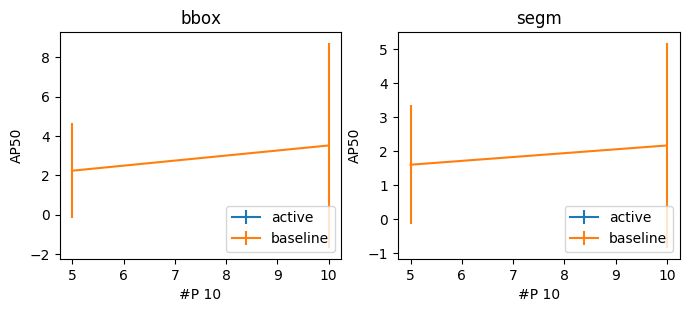

In [2]:
print('alpha - overall mean and var')

compare(
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-11-2021/20:14:39',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/15-11-2021/03:05:29',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/default/no_noise/15-11-2021/03:05:39',
#     '/checkpoint/soumith/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-11-2021/11:46:08', 
#     '/checkpoint/aszlam/jobs/active_vision/pipeline/apartment_0/default/no_noise/09-11-2021/12:44:01',
#     '/checkpoint/soumith/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/15-11-2021/15:54:17', # 5 traj sanity check
#     '/checkpoint/aszlam/jobs/active_vision/pipeline/apartment_0/default/no_noise/15-11-2021/16:06:36', # 5 traj sanity check
    '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/class/baseline/no_noise/22-12-2021/23:17:27',
    '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/class/circle/no_noise/22-12-2021/23:03:34',
    50, [5,10,15,20,25], [5], act_pref='default', metric='alpha', xlabel=f'#P {10}', num_samples=2
)

gt 10, p 0, bbox 9.833884719774904, segm 8.889319462243538, bbox samples 86, segm samples 86
gt 10, p 5, bbox 9.580380142025273, segm 8.208293440366864, bbox samples 88, segm samples 88
gt 10, p 10, bbox 10.27811457669042, segm 8.81448593249369, bbox samples 90, segm samples 90
gt 10, p 15, bbox 10.163792707111206, segm 8.341131393442591, bbox samples 86, segm samples 86
gt 10, p 20, bbox 10.469977095756159, segm 8.489361129041848, bbox samples 90, segm samples 90
gt 10, p 25, bbox 10.814380292836784, segm 8.807893089741292, bbox samples 90, segm samples 90
gt 10, p 0, bbox 10.193297040996342, segm 8.792215063388658, bbox samples 94, segm samples 94
gt 10, p 5, bbox 10.174348042643407, segm 8.288266030151416, bbox samples 94, segm samples 94
gt 10, p 10, bbox 10.243300818095282, segm 8.35017828545, bbox samples 90, segm samples 90
gt 10, p 15, bbox 9.892659621400188, segm 7.949298613825022, bbox samples 88, segm samples 88
gt 10, p 20, bbox 9.625682544416648, segm 7.691667865921534, bb

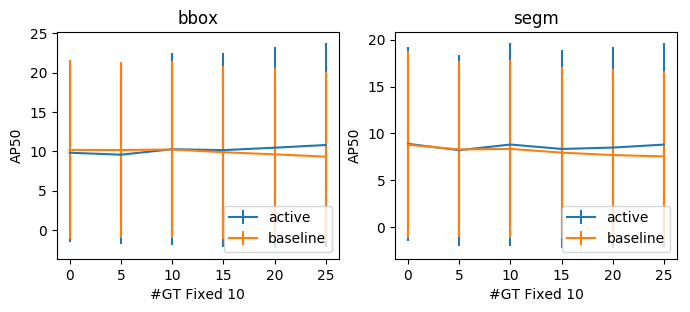

In [6]:

compare(
#     '/checkpoint/soumith/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/15-11-2021/15:54:17', # sanity check
#     '/checkpoint/aszlam/jobs/active_vision/pipeline/apartment_0/default/no_noise/15-11-2021/16:06:36', # sanity check
    '/checkpoint/aszlam/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/15-11-2021/18:47:55',
    '/checkpoint/kavyasrinet/jobs/active_vision/pipeline/apartment_0/default/no_noise/15-11-2021/21:17:14',
    50, [10], [0,5,10,15,20,25], act_pref='default', metric='alpha', xlabel=f'#GT Fixed {10}', num_samples=2
)

gt 10, p 0, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 10, p 5, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 10, p 10, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 10, p 15, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 10, p 20, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 10, p 25, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 10, p 0, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 10, p 5, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 10, p 10, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 10, p 15, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 10, p 20, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 10, p 25, bbox nan, segm nan, bbox samples 0, segm samples 0


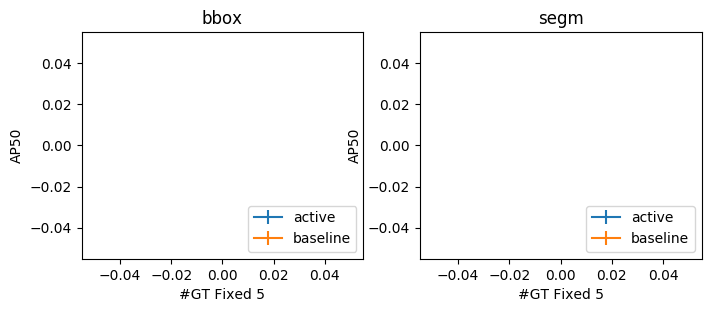

In [41]:
compare(
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/15-11-2021/03:05:29',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/default/no_noise/15-11-2021/03:05:39',
    '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/15-11-2021/12:31:30',
    '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/default/no_noise/15-11-2021/12:31:41',
    1, [10], [0,5,10,15,20,25], act_pref='default', metric='alpha', xlabel=f'#GT Fixed {5}', num_samples=1
)